In [295]:
#spacy
import spacy
import en_core_web_lg
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc, Span
from spacy.matcher import Matcher, PhraseMatcher 
from scripts.spacy_model import load_results_auto, load_results_manual

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
#import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines
import json
import os
import csv

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import time
#warning
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lewagonlew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lewagonlew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [175]:
PATH = os.path.dirname(os.path.dirname(os.getcwd()))
PATH

'/home/lewagonlew/code/marcorodrigues/skills_matcher/skills_matcher'

In [245]:
nlp_ms = spacy.blank("en")
skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"

ruler = nlp_ms.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp_ms.pipe_names

['entity_ruler']

In [212]:
#resume data from kaggle - for tryout
df = pd.read_csv(PATH + "/data/Resume/Resume.csv")


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [298]:
df.shape

(400, 8)

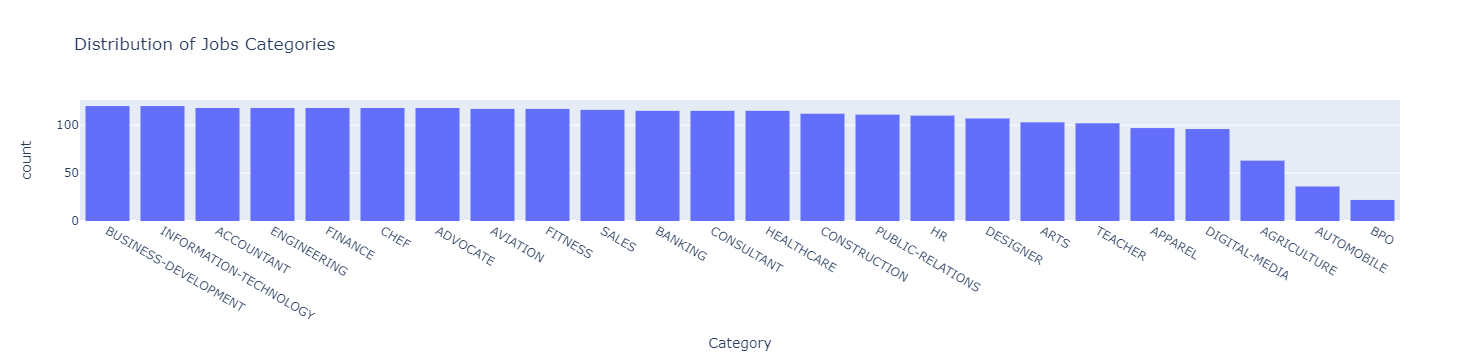

In [213]:
fig = px.histogram(
    df, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [214]:
df = df.reindex(np.random.permutation(df.index))
df = df.copy().iloc[
    0:400,
]
df.head()

,ID,Resume_str,Resume_html,Category
1561,66741193,DIRECTOR OF FINANCE Executive...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
1636,29764492,DESIGN DIRECTOR / SENIOR DESIGNER ...,"<div class=""skn-cbg1 fontsize fontface vmargin...",APPAREL
254,46260230,INFORMATION TECHNOLOGY SPECIALIST(DIS...,"<div class=""RNA skn-hdr3 fontsize fontface vma...",INFORMATION-TECHNOLOGY
868,12092347,SALES ASSOCIATE Professiona...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS
1628,23719943,SR. FREELANCE DESIGNER/PRODUCT DEVELO...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL


In [199]:
#different cleaning function
def clean_resume(df):
    clean = []
    for i in range(df.shape[0]):
        review = re.sub(
            '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
            " ",
            df["Resume_str"].iloc[i],
        )
        review = review.lower()
        review = review.split()
        lm = WordNetLemmatizer()
        review = [
            lm.lemmatize(word)
            for word in review
            if not word in set(stopwords.words("english"))
        ]
        review = " ".join(review)
        clean.append(review)
    return clean

In [216]:
df["Clean_Resume"] = clean_resume(df)
df["marked_text"] = df["Clean_Resume"].str.lower().apply(nlp_ms)
df["skills"] = df["marked_text"].apply(create_skill_list)
df.reset_index(inplace = True)
df.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,marked_text
1561,66741193,DIRECTOR OF FINANCE Executive...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,director finance executive profile ambitious f...,"(director, finance, executive, profile, ambiti..."
1636,29764492,DESIGN DIRECTOR / SENIOR DESIGNER ...,"<div class=""skn-cbg1 fontsize fontface vmargin...",APPAREL,design director senior designer professional s...,"(design, director, senior, designer, professio..."
254,46260230,INFORMATION TECHNOLOGY SPECIALIST(DIS...,"<div class=""RNA skn-hdr3 fontsize fontface vma...",INFORMATION-TECHNOLOGY,information technology specialist discountpcfi...,"(information, technology, specialist, discount..."
868,12092347,SALES ASSOCIATE Professiona...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,sale associate professional summary jack trade...,"(sale, associate, professional, summary, jack,..."
1628,23719943,SR. FREELANCE DESIGNER/PRODUCT DEVELO...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,sr freelance designer product development mana...,"(sr, freelance, designer, product, development..."


In [38]:
set(flat_list)

{'accounting',
 'advertising',
 'business',
 'business administration',
 'commerce',
 'data analysis',
 'design',
 'documentation',
 'front end',
 'interaction',
 'marketing',
 'medium',
 'segment',
 'server',
 'support',
 'swift'}

In [ ]:
test_resume = nlp_ms(df["Resume_str"].iloc[0])
resume_ents = [(ent.text, ent.label_) for ent in test_resume.ents]
displacy.render(test_resume, style="ent", jupyter=True)
print(resume_ents)

In [253]:
#functions for getting entities text, label, start and end of character position
def create_skill_set(text, model = False):
    '''Apply basic spacy model and Create a set of the extracted skill entities'''
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp(text)
        
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' or 'knowledge' in ent.label_.lower()])

def create_skill_position(doc):
    '''Create a set of the extracted skill entities of a doc'''
    #nlp_doc = nlp_ms(doc)
    #[(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in sent.ents]
    return list([ent.start_char, ent.end_char, ent.label_] for ent in doc.ents )

#def create_skillset_dict(resume_texts):
#    '''Create a dictionary containing a set of the extracted skills. Name is key, matching skillset is value'''
#    skillsets = [create_skill_set(resume_text) for resume_text in resume_texts]
#   return skillsets

def create_skill_list(text, model = False):
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp_ms(text)
    
    t = list([ent.text] for ent in doc.ents )
    flat_list = [item for sublist in t for item in sublist]
    return set(flat_list)

def match_skills(JD_data_set, cv_set):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    pct_list = []
    
    if len(cv_set) < 1:
        print('could not extract skills from resume text')   
    else:
        #implement function comparing with a list of job_descriptions
        for i in range(0, len(JD_set)):
            match = cv_set & JD_set[i] 
            qu = len(cv_set & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
        pct_list.sort(key=lambda x: x[1], reverse = True)s
    
        #print("Resume has a {}% skill match on job offer".format(pct_match))
        #print('Required skills: {} '.format(JD_set))
        #print('Matched skills: {} \n'.format(JD_set.intersection(skillset_dict[resume_name])))
        
    return pct_list[0:9]

In [73]:
# compare df.skills with test_list
cv_set = test_list
JD_set = df.skills
pct_list = match_skills(JD_set, cv_set)

In [397]:
df.shape()

(400, 5)

In [138]:
pct_list = match_skills(JD_set, cv_set)

In [461]:
job_number, matching_score, job_cat = [], [], []
frame = pd.DataFrame

for i in pct_list:
    cat = df["Category"][i[0]]
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    
    if cat in job_cat:
        job_cat.append(str(cat) + str(i[0]))
    else:
        job_cat.append(cat)
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = job_cat

Job #96 in Sector SALES has a 100.0% match
Job #111 in Sector AGRICULTURE has a 66.67% match
Job #169 in Sector AGRICULTURE has a 66.67% match
Job #95 in Sector ENGINEERING has a 60.0% match
Job #0 in Sector FINANCE has a 50.0% match
Job #19 in Sector AVIATION has a 50.0% match
Job #20 in Sector ENGINEERING has a 50.0% match
Job #37 in Sector BUSINESS-DEVELOPMENT has a 50.0% match
Job #52 in Sector ACCOUNTANT has a 50.0% match


In [462]:
frame

,job_number,matching_score,Category
0,96,100.00,SALES
1,111,66.67,AGRICULTURE
2,169,66.67,AGRICULTURE169
3,95,60.00,ENGINEERING
4,0,50.00,FINANCE
5,19,50.00,AVIATION
6,20,50.00,ENGINEERING20
7,37,50.00,BUSINESS-DEVELOPMENT
8,52,50.00,ACCOUNTANT


In [434]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [465]:
frame["color"] = '0'

In [479]:
frame.matching_score[0]

100.0

In [481]:
for i in range(0, len(frame)):
    frame["color"]=np.array(['rgb(255,255,255)']*np.array(frame.matching_score[i]))

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [482]:
frame["color"][0:2] = 'rgb(240,150,255)'
frame["color"][2:5] = 'blue'
frame["color"][5:8] = 'yellow'
frame["color"][8:] = 'red'

In [476]:
frame

,job_number,matching_score,Category,color
0,96,100.00,SALES,green
1,111,66.67,AGRICULTURE,green
2,169,66.67,AGRICULTURE169,blue
3,95,60.00,ENGINEERING,blue
4,0,50.00,FINANCE,blue
5,19,50.00,AVIATION,yellow
6,20,50.00,ENGINEERING20,yellow
7,37,50.00,BUSINESS-DEVELOPMENT,yellow
8,52,50.00,ACCOUNTANT,red


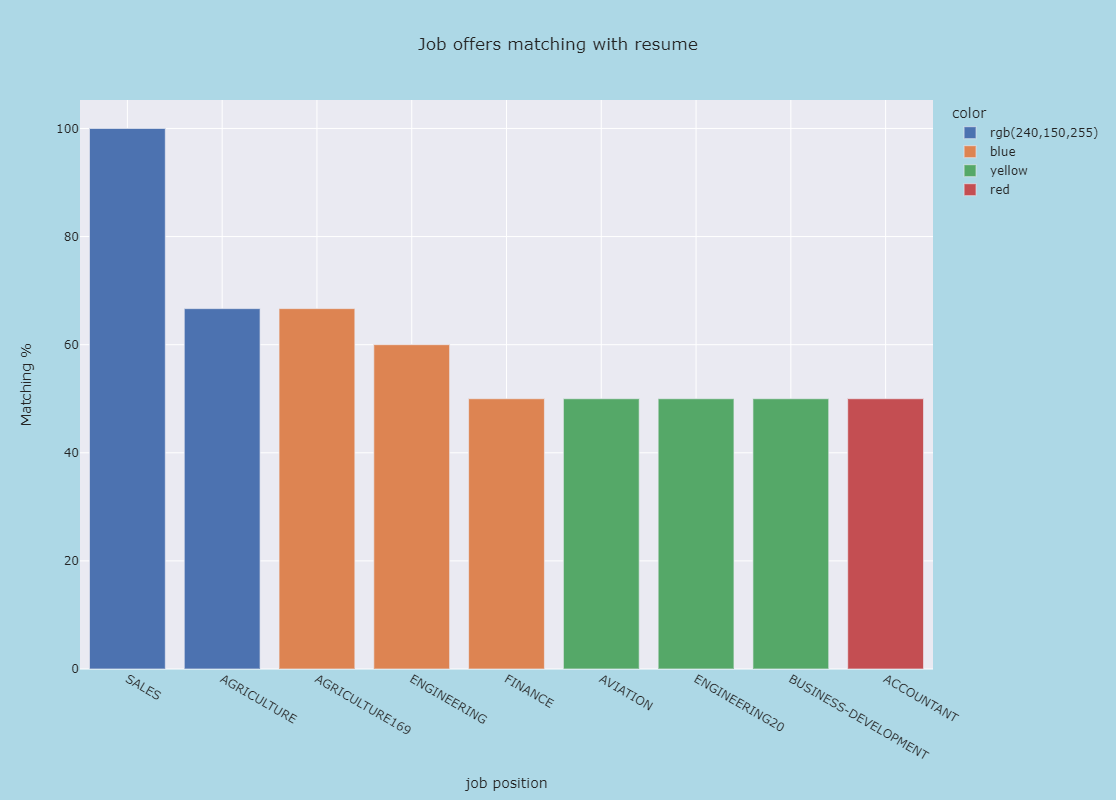

In [483]:
## compare list with data_set, visualize highest matching jobs

#for template in ["ggplot2", "seaborn"]:
import plotly.graph_objects as go

fig = px.bar(
    x=frame['Category'], 
    y=frame["matching_score"],
    labels={"x": "job position", "y": "Matching %"},
    title=f"Job offers matching with resume",
    width=1200, height=800,
    template="seaborn",
    color = frame["color"])
fig.update_layout(
        #margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="lightblue",
)
fig.show()

In [ ]:
## comparison of test_resume with automated_annotated_JD data

In [ ]:
print("Resume has a {}% skill match on job offer".format(pct_match))
print('Required skills: {} '.format(JD_set))
print('Matched skills: {} \n'.format(JD_set.intersection(skillset_dict[resume_name])))

## Loading Data with pre-trained Spacy Model (Auto/Manual)

In [170]:
%load_ext autoreload
%autoreload 2
from scripts.spacy_model import load_results_auto, load_results_manual

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
def load_paths(data_name, dictionary_name, train_spacy_name, val_spacy_name):
    PATH_TRAIN_DATA  = f"{PATH}/skills_matcher/models/{train_spacy_name}.spacy"
    PATH_VAL_DATA  = f"{PATH}/skills_matcher/models/{val_spacy_name}.spacy"
    PATH_DICT = f"{PATH}/skills_matcher/data/dictionaries/{dictionary_name}.jsonl"
    PATH_DATA = f"{PATH}/skills_matcher/data/{data_name}.csv"
    return PATH_DATA, PATH_DICT, PATH_TRAIN_DATA, PATH_VAL_DATA

In [176]:
PATH_DATA, PATH_DICT, PATH_TRAIN_DATA, PATH_VAL_DATA = load_paths('cleaned_data', 'doccano_dictionary', 'train', 'val')

In [401]:
df_JD = pd.read_csv('../data_final_raw.csv')
df_JD.head()

,Unnamed: 0,ISCO,major_job,job,position,location,description,entities_auto_label,entities_manual_label
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'..."
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'..."
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':..."
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit..."
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)",[]


In [399]:
df_JD.shape

(3507, 9)

In [403]:
df_JD.drop(columns = ["major_job", "ISCO", "location"], inplace = True)

In [453]:
df_JD

,Unnamed: 0,job,position,description,entities_auto_label,entities_manual_label
0,0,physicist,Accelerator Physicist id54315,[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'..."
1,1,physicist,Accelerator Physicist id54315,[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'..."
2,2,physicist,Accelerator Physicist id54315,[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':..."
3,3,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit..."
4,4,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,[' Be in charge of the development of applicat...,"(Python, Python)",[]
...,...,...,...,...,...,...
3502,3502,veterinary surgeon,Veterinary Surgeon,[' Allocated CPD funding of 37.5 hours Excelle...,(),"[{'entity': driving licence, 'label': 'KNOWLED..."
3503,3503,veterinary surgeon,Permanent Veterinary Surgeon,[' Type: Small Animal Hours: Monday - Friday 4...,(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3504,3504,veterinary surgeon,Veterinary Surgeon,"[' Allocated CPD funding of 37.5 hours ', ' 5 ...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3505,3505,veterinary surgeon,Permanent Veterinary Surgeon,"["" Experienced required: New Graduate level to...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."


In [ ]:
data_cleaned = data.apply(get_dict, axis=1)

# Resume data

In [ ]:
df_Resume = pd.read_csv(PATH + "/data/Resume.csv")
df_Resume.head()

In [202]:
df_Resume["Clean_Resume"] = clean_resume(df_Resume)
df_Resume.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist u hr operation summary versatile...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr director summary 20 year experience recruit...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr manager skill highlight hr skill hr departm...


In [204]:
# talking smaller, randomized subsample
df_Resume = df_Resume.reindex(np.random.permutation(df_Resume.index))
df_Resume_small = df_Resume.copy().iloc[
    0:600,
]
df_Resume_small.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume
1933,26509539,CONSTRUCTION INSTALLER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction installer summary detail oriented...
310,29975124,CONSULTANT Experience Co...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,consultant experience consultant 05 2017 curre...
1615,12668625,BOOKSELLER Professional Profi...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,bookseller professional profile ever since abl...
619,25370801,BUSINESS DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development consultant summary experi...
1393,28424982,EXECUTIVE CHEF Executive Profil...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,executive chef executive profile twenty year p...


In [ ]:
df_Resume_small['entities_auto_label'] = df_Resume_small.Clean_Resume.apply(load_results_auto)
df_Resume_small

In [ ]:
%%time
df_Resume_small['entities_manual_label'] = df_Resume_small.Clean_Resume.apply(load_results_manual)
df_Resume_small

In [ ]:
df_Resume_small["marked_text"] = df_Resume_small["Clean_Resume"].str.lower().apply(nlp_ms)
df_Resume_small["skills"] = df_Resume_small["marked_text"].apply(create_skill_list)
df_Resume_small.reset_index(inplace = True)

In [ ]:
df_Resume_small.drop(columns = ["index", "ID", "marked_text"], inplace = True)
df_Resume_small.reset_index(inplace = True)
df_Resume_small.head()

In [238]:
df_Resume_small.rename(columns = {"skills":"entity_ruler"})

,index,Resume_str,Resume_html,Category,Clean_Resume,entities_auto_label,entities_manual_label,entity_ruler
0,0,CONSTRUCTION INSTALLER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction installer summary detail oriented...,"((go),)",[],"{project management, material, box, go, schedu..."
1,1,CONSULTANT Experience Co...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,consultant experience consultant 05 2017 curre...,"((deployment), (c), (c), (shell), (shell), (c)...","[{'entity': (5, 2, o), 'label': 'MIN_EXP'}, {'...","{database, business, computer science, c, soft..."
2,2,BOOKSELLER Professional Profi...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,bookseller professional profile ever since abl...,(),"[{'entity': (english, learning), 'label': 'KNO...","{play, schedule, security, material}"
3,3,BUSINESS DEVELOPMENT CONSULTANT ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development consultant summary experi...,"((c),)",[],"{c, business, material}"
4,4,EXECUTIVE CHEF Executive Profil...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,executive chef executive profile twenty year p...,"((dietary),)",[],"{support, chef, business, marketing}"
...,...,...,...,...,...,...,...,...
595,595,MARKETING & SALES ANALYST Sum...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,marketing sale analyst summary result oriented...,"((medium), (publishing))",[],"{documentation, medium, publishing, business, ..."
596,596,LEAD UX/UI DESIGNER Executive P...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,lead ux ui designer executive profile insightf...,"((lpl), (logo), (medium), (medium), (medium), ...","[{'entity': (1, 6, million), 'label': 'MIN_EXP'}]","{advertising, medium, logo, business, marketin..."
597,597,ELECTRONIC TECHNICIAN II Prof...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,electronic technician ii profile acquire elect...,"((c), (fusion), (florida), (go), (c))","[{'entity': (frc753, ps213), 'label': 'KNOWLED...","{documentation, material, visual inspection, c..."
598,598,PERSONAL STYLIST- WOMEN'S DESIGNER ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,personal stylist woman designer summary eager ...,"((c),)",[],"{business administration, business, marketing,..."


In [230]:
df_Resume_small["entities_auto_label"][597]

(c, fusion, florida, go, c)

In [231]:
df_Resume_small["entities_manual_label"][597]

[{'entity': frc753 ps213, 'label': 'KNOWLEDGE'}]

In [233]:
df_Resume_small["skills"][597]

{'c',
 'component',
 'design',
 'documentation',
 'electronic engineering',
 'fusion',
 'go',
 'material',
 'monitoring',
 'residual',
 'security',
 'specification',
 'terminal',
 'vault',
 'visual inspection'}

In [390]:
def extract_resume_skills(text):
    #test_resume = df["Clean_Resume"]
    test_list = create_skill_list(text, model = True)
    test_list_2 = load_results_manual(test_resume)
    
    set_list = []
    for i in range(0, len(test_list_2)):
        set_list.append(str(test_list_2[i]["entity"]).lower().strip())
        
    ext = set.union(test_list, set(set_list))
    
    return ext

In [452]:
def get_dict(x):
    dict_ = {}
    entities = extract_entities_2(x['entities_manual_label'])
    labels = extract_lables(x['entities_manual_label'])
    for index, key in enumerate(entities):
        if key not in dict_.keys():
            dict_[key] = labels[index]
    skills_auto =extract_skills_auto(x['entities_auto_label'])
    for index, value in enumerate(skills_auto):
        if value not in dict_.keys():
            dict_[value] = 'SKILL'
    skills_list = []
    knowledge_list = []
    min_exp_list = []
    level_list = []
    for entity, label in dict_.items():
        if label == 'SKILL':
            skills_list.append(entity)
        if label == 'KNOWLEDGE':
            knowledge_list.append(entity)
        if label == 'MIN_EXP':
             min_exp_list.append(entity)
        if label == 'LEVEL':
            level_list.append(entity)
    x["SKILL"] = skills_list
    x["KNOWLEDGE"] = knowledge_list
    x["MIN_EXP"] = min_exp_list
    x["LEVEL"] = level_list
    return x

In [386]:
test_resume = df_Resume_small["Clean_Resume"][400]

In [391]:
skill_list = extract_resume_skills(test_resume)

In [392]:
skill_list

{'azure',
 'business',
 'component',
 'computer network',
 'computer science',
 'desktop server',
 'emc networker',
 'fedora',
 'financial system',
 'geographic information system',
 'go',
 'help desk',
 'linux',
 'microsoft system center',
 'mobile',
 'monitoring',
 'network interface',
 'network security',
 'operating system',
 'router',
 'security',
 'server',
 'skype',
 'software',
 'support',
 'unix',
 'visual basic'}

In [395]:
df_JD

,Unnamed: 0,ISCO,major_job,job,position,location,description,entities_auto_label,entities_manual_label
0,0,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': physics, 'label': 'KNOWLEDGE'}, {'..."
1,1,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': RICS, 'label': 'SKILL'}, {'entity'..."
2,2,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Accelerator Physicist id54315,"Villigen PSI, Aargau",[' You have an academic degree in physics or e...,(),"[{'entity': CIS, 'label': 'SKILL'}, {'entity':..."
3,3,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)","[{'entity': Python, 'label': 'SKILL'}, {'entit..."
4,4,21,SCIENCE AND ENGINEERING PROFESSIONALS,physicist,Applied Physicist (Computing) (EP-LBC-2021-125...,Geneva,[' Be in charge of the development of applicat...,"(Python, Python)",[]
...,...,...,...,...,...,...,...,...,...
3502,3502,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,England,[' Allocated CPD funding of 37.5 hours Excelle...,(),"[{'entity': driving licence, 'label': 'KNOWLED..."
3503,3503,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Cricklewood, North West London",[' Type: Small Animal Hours: Monday - Friday 4...,(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3504,3504,22,HEALTH PROFESSIONALS,veterinary surgeon,Veterinary Surgeon,"Middlesbrough, North Yorkshire","[' Allocated CPD funding of 37.5 hours ', ' 5 ...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."
3505,3505,22,HEALTH PROFESSIONALS,veterinary surgeon,Permanent Veterinary Surgeon,"Harrogate, North Yorkshire","["" Experienced required: New Graduate level to...",(),"[{'entity': driver's license, 'label': 'KNOWLE..."


In [ ]:
data_cleaned = df_JD.apply(get_dict, axis=1)

In [337]:
cv_set = skill_list
JD_set = df.skills
pct_list = match_skills(JD_set, cv_set)

In [331]:
#functions for getting entities text, label, start and end of character position
def create_skill_set(text, model = False):
    '''Apply basic spacy model and Create a set of the extracted skill entities'''
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp(text)
        
    return set([ent.label_.upper()[6:] for ent in doc.ents if 'skill' or 'knowledge' in ent.label_.lower()])


def create_skill_list(text, model = False):
    
    if model == True:
        nlp_ms = spacy.blank("en")
        skill_pattern_path = PATH + "/data/dictionaries/complete_dict.jsonl"
        ruler = nlp_ms.add_pipe("entity_ruler")
        ruler.from_disk(skill_pattern_path)
        doc = nlp_ms(text)
    
    t = list([ent.text] for ent in doc.ents )
    flat_list = [item for sublist in t for item in sublist]
    return set(flat_list)



In [394]:
def match_skills(JD_data_set, cv_set):
    '''Get intersection of resume skills and job offer skills and return match percentage'''
    pct_list = []
    
    if len(cv_set) < 1:
        print('could not extract skills from resume text')   
    else:
        #implement function comparing with a list of job_descriptions
        for i in range(0, len(JD_set)):
            match = cv_set & JD_set[i] 
            qu = len(cv_set & JD_set[i])
            di = len(JD_set[i])
            pct_match = round((qu/di) * 100, 2)
            pct_list.append([i, pct_match])
            
        pct_list.sort(key=lambda x: x[1], reverse = True)
    
        
    return pct_list[0:9]

In [ ]:
job_number, matching_score, job_cat = [], [], []

for i in pct_list:
    cat = df["Category"][i[0]]
    print('Job #{} in Sector {} has a {}% match'.format(i[0], df["Category"][i[0]], i[1]))
    job_number.append(i[0])
    matching_score.append(i[1])
    
    if cat in job_cat:
        job_cat.append(str(cat) + str(i[0]))
    
frame = pd.DataFrame(job_number, columns=['job_number'])
frame["matching_score"] = matching_score
frame["Category"] = df["Category"][i[0]]